# data set definitions for rollouts 

> Definitions of various data sets used in learning with offline rollouts.

In [ ]:
#| default_exp data.loaders

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from fastcore import *
from fastcore.utils import *

## V3 Dataset

In [ ]:
#| export
import torch
import os, sys
import numpy as np
from torchvision import datasets, transforms
import torch.nn.functional as F
class MarlGridDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, num_agents= 2, train= True, seq_len= 64, msg_tf= None, transform=None):
        self.data = data_path
        self.rollouts = [os.path.join(self.data, f) 
                         for f in os.listdir(data_path) 
                         if os.path.isfile(os.path.join(data_path, f))]
        
        self.train_rollouts = self.rollouts[:int(0.8*len(self.rollouts))]
        self.test_rollouts = self.rollouts[int(0.8*len(self.rollouts)):]
        self.train = train
        if train:
            self.rollouts = self.train_rollouts
        else:
            self.rollouts = self.test_rollouts
            
        void_tf = transforms.Compose([
            transforms.ToTensor(),
        ])
        self.transform = transform if transform else void_tf
        self.msg_tf = msg_tf if msg_tf else lambda x: x
        self.seq_len = seq_len
        self.agents = [f"agent_{i}" for i in range(num_agents)]

    def __len__(self):
        if self.train:
            return len(self.train_rollouts)
        else:
            return len(self.test_rollouts)
    
    def sample_idxs(self, episode_len):
        idxs = np.arange(episode_len)
        start = np.random.randint(0, len(idxs) - self.seq_len)
        seq = idxs[start:start + self.seq_len]
        return seq
    
    def __getitem__(self, idx):
        path = self.rollouts[idx]
        data = np.load(path, allow_pickle=True)
        episode_len = data['episode_len'].item()
        loaded_rollout = False
        try:
            seq = self.sample_idxs(episode_len)
            loaded_rollout = True

        except Exception as e:
            loaded_rollout = False
            idx = np.random.randint(0, len(self))
            return self.__getitem__(idx)
        
        return {
            f"{ag}": 
                    {
                    "obs": torch.stack([self.transform(frame) for frame in data[f"{ag}_obs"][seq]]),
                    "pos": torch.from_numpy(data[f"{ag}_selfpos"][seq]),
                    "msg": torch.stack([self.msg_tf((frame, ag, done, True)) for frame, done in zip(data[f"{ag}_obs"][seq], data[f"{ag}_done"][seq])]),
                    "msg_target": torch.stack([self.msg_tf((frame, ag, done, False)) for frame, done in zip(data[f"{ag}_obs"][seq], data[f"{ag}_done"][seq])]),                    
                    "act": F.one_hot(torch.from_numpy(np.asarray(data[f"{ag}_act"][seq])), num_classes=5).float(),
                    "next_obs": torch.stack([self.transform(frame) for frame in data[f"{ag}_next_obs"][seq]]),
                    "done": torch.stack([torch.from_numpy(data[f"{ag}_done"][seq])], dim=1),
                    } 
            for ag in (self.agents)}
            
        

In [ ]:
#| hide
from torchvision.transforms import v2
from mawm.data.utils import msg_tf
tf = v2.Compose([
    v2.ToPILImage(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

data_path = './data_test/'
dataset = MarlGridDataset(data_path, num_agents=2, seq_len=17, transform=tf, msg_tf=msg_tf)

/home/ahmed/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#| hide
rollout = dataset[0]

In [ ]:
#| hide
rollout.keys()

dict_keys(['agent_0', 'agent_1'])

In [ ]:
#| hide
print([rollout['agent_0'][k].shape for k ,v in rollout['agent_0'].items()])

[torch.Size([17, 3, 42, 42]), torch.Size([17, 2]), torch.Size([17, 5, 7, 7]), torch.Size([17, 7, 7]), torch.Size([17, 5]), torch.Size([17, 3, 42, 42]), torch.Size([17, 1])]


In [ ]:
#| hide
rollout['agent_0']['act'].shape 

torch.Size([17, 5])

In [ ]:
#| hide
{k:rollout['agent_0'][k].dtype for k ,v in rollout['agent_0'].items()}

{'obs': torch.float32,
 'pos': torch.int64,
 'msg': torch.float32,
 'msg_target': torch.int64,
 'act': torch.float32,
 'next_obs': torch.float32,
 'done': torch.bool}

In [ ]:
#| hide
rollout['agent_0']['obs'].min(), rollout['agent_0']['obs'].max()

(tensor(-1.), tensor(1.))

In [ ]:
#| hide
print(rollout['agent_0']['msg'][0].shape)
rollout['agent_0']['obs'][0].permute(1,2,0).numpy().shape

torch.Size([5, 7, 7])


(42, 42, 3)

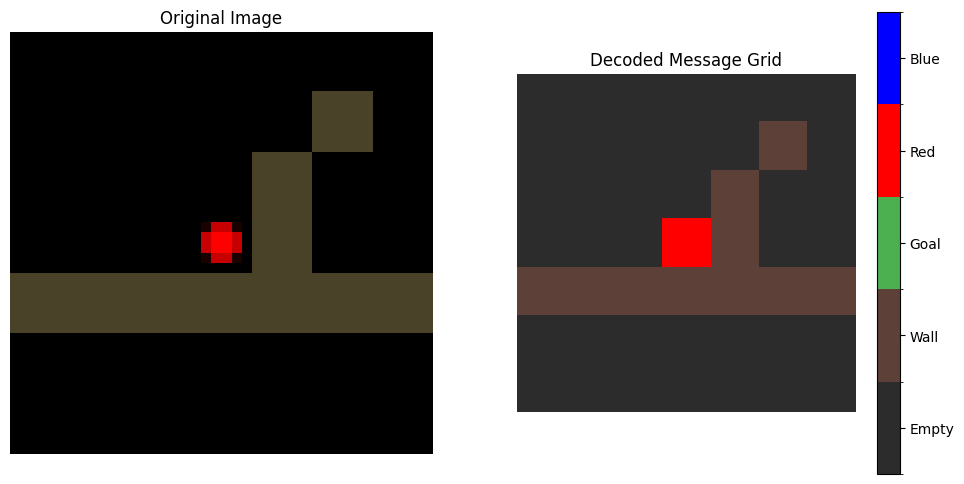

In [ ]:
#| hide
from mawm.data.utils import plot_grid
denormalize = lambda x: (x * 0.5) + 0.5
img = denormalize(rollout['agent_0']['obs'][0].permute(1,2,0).numpy())
plot_grid(img, rollout['agent_0']['msg'][0].permute(1,2,0))

In [ ]:
#| hide
rollout['agent_0']['act'].shape


torch.Size([17, 5])

In [ ]:
#| hide
dones = rollout['agent_0']['done']
print(dones.shape)
dones = dones.unsqueeze(0)
print(dones.shape)
mask = (~dones.bool()).float()
mask.shape

torch.Size([17, 1])
torch.Size([1, 17, 1])


torch.Size([1, 17, 1])

['Done', 'Down', 'Up', 'Done']


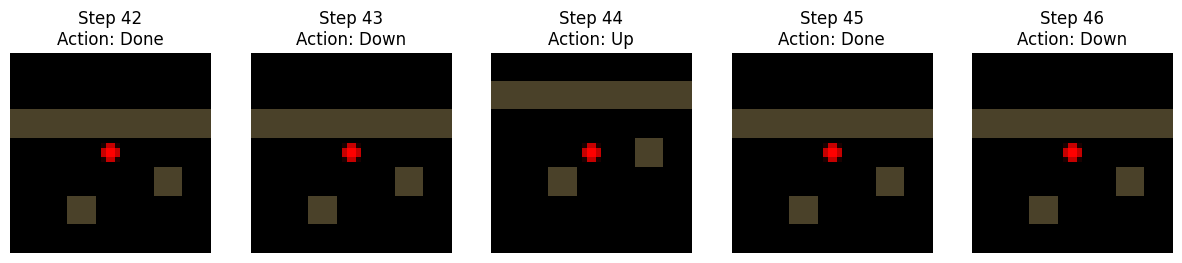

In [ ]:
# #| hide
# import matplotlib.pyplot as plt
# action_mapping = {
#     0: "Right",
#     1: "Down",
#     2: "Left",
#     3: "Up",
#     4: "Done",
#     }

# fig, axs = plt.subplots(1, 5, figsize=(15,6))
# idx = 0
# ds = rollout
# idx = np.random.randint(0, ds['agent_0']['obs'].shape[0] - 5)
# for i in range(idx, idx + 5):
#     obs = ds['agent_0']['obs'][i]
#     next_obs = ds['agent_0']['next_obs'][i]
#     ax = axs[i - idx]
#     ax.imshow(obs.permute(1, 2, 0).numpy() * 0.5 + 0.5)
#     ax.set_title(f"Step {i}\nAction: {action_mapping[ds['agent_0']['act'][i].item()]}")
#     ax.axis('off')
# print([action_mapping[a.item()] for a in ds['agent_0']['act'][idx:idx + 4]])
# plt.savefig('example_rollout_steps.png')
# plt.show()

In [ ]:
#| hide
dl = torch.utils.data.DataLoader(dataset, batch_size= 4, shuffle= True)
batch = next(iter(dl))


In [ ]:
#| hide
dones = batch['agent_0']['done']
dones.shape

torch.Size([4, 17, 1])

In [ ]:
#| hide
dones

tensor([[[ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True]],

        [[False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         [False],
    

In [ ]:
#| hide
mask = (~dones.bool()).float()
mask.shape

torch.Size([4, 17, 1])

## Base Dataset

In [ ]:
#| export
from bisect import bisect
from os import listdir
from os.path import join, isdir
from tqdm import tqdm
import torch
import torch.utils.data
import numpy as np


In [ ]:
#| export
class _RolloutDataset(torch.utils.data.Dataset): 
    def __init__(self, agent, root, transform, buffer_size=200, seq_len= 50, train=True, obs_key = 'pov'): # pylint: disable=too-many-arguments
        
        self.agent = agent
        self._transform = transform
        self.obs_key = obs_key
        self.seq_len = seq_len
        self._files = [join(root, sd) for sd in listdir(root)]

        def train_test_split(files, train):
            if train:
                return files[:-600]
            else:
                return files[-600:]

        self._files = train_test_split(self._files, train)
        self._cum_size = None
        self._buffer = None
        self._buffer_fnames = None
        self._buffer_index = 0
        self._buffer_size = buffer_size

    def sample_sequence(self, rollout, agent, seq_len):

        episode_len = rollout["episode_len"].item()
        start = np.random.randint(0, episode_len)
        start = min(start, episode_len - seq_len)
        print(f"Sampling sequence for {agent} from index {start} to {start + seq_len}")

        end = start + seq_len

        obs = rollout[f"{agent}_obs"][start:end]
        rew = rollout[f"{agent}_rew"][start:end]
        act = rollout[f"{agent}_act"][start:end]
        info = rollout[f"{agent}_info"][start:end]

        data = {
            f"{agent}_obs": obs,
            f"{agent}_rew": rew,
            f"{agent}_act": act,
            f"{agent}_info": info
        }
        return data

    def load_next_buffer(self):
        """ Loads next buffer """
        self._buffer_fnames = self._files[self._buffer_index:self._buffer_index + self._buffer_size]
        self._buffer_index += self._buffer_size
        self._buffer_index = self._buffer_index % len(self._files)
        self._buffer = []
        self._cum_size = [0]

        # progress bar
        pbar = tqdm(total=len(self._buffer_fnames),
                    bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} {postfix}')
        pbar.set_description("Loading file buffer ...")

        for f in self._buffer_fnames:
            with np.load(f, allow_pickle= True) as data:
                rollout = self.sample_sequence(data, self.agent, self.seq_len)
                self._buffer += [rollout] # list of dicts,each dict is an episode data
                self._cum_size += [self._cum_size[-1] + self.seq_len]
            pbar.update(1)
        pbar.close()

    def __len__(self):
        if not self._cum_size:
            self.load_next_buffer()
        return self._cum_size[-1]

    def __getitem__(self, i):
        # binary search through cum_size
        file_index = bisect(self._cum_size, i) - 1
        seq_index = i - self._cum_size[file_index]
        data = self._buffer[file_index]
        return self._get_data(data, seq_index)
    
    def reset_buffer(self):
        self._buffer = None
        self._cum_size = None
        self._buffer_fnames = None
        self._buffer_index = 0  

    def _get_data(self, data, seq_index):
        raise NotImplementedError

    def _data_per_sequence(self, data_length):
        raise NotImplementedError

## Observation Dataset

In [ ]:
#| export
class RolloutObservationDataset(_RolloutDataset): # pylint: disable=too-few-public-methods

    def _data_per_sequence(self, data_length):
        return data_length

    def _get_data(self, data, seq_index):
        done = data[f'{self.agent}_info'][seq_index]['done']
        obs = data[f'{self.agent}_obs'][seq_index][self.obs_key].astype(np.uint8)
        act = data[f'{self.agent}_act'][seq_index]
        return self._transform(obs), act, done, self.agent


In [ ]:
# # | hide
# from torchvision import transforms
# import numpy as np

# tf = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((42, 42)),
#     transforms.ToTensor(),
#     # transforms.Normalize((0.5, 0.5, 0.5),
#     #                      (0.5, 0.5, 0.5)),
# ])

# void_tf = transforms.Lambda(lambda x: x)
# dataset = RolloutObservationDataset(
#     agent='agent_0',
#     root='../marl_grid_data/',
#     transform=void_tf,
#     buffer_size=10,
#     train=True
# )
# # dataset.load_next_buffer()

In [ ]:
# dataset.load_next_buffer()

Loading file buffer ...:  10%|█         | 1/10 

Sampling sequence for agent_0 from index 889 to 939
Sampling sequence for agent_0 from index 243 to 293
Sampling sequence for agent_0 from index 435 to 485


Loading file buffer ...:  30%|███       | 3/10 

Sampling sequence for agent_0 from index 1510 to 1560


Loading file buffer ...:  80%|████████  | 8/10 

Sampling sequence for agent_0 from index 201 to 251
Sampling sequence for agent_0 from index 44 to 94
Sampling sequence for agent_0 from index 17 to 67
Sampling sequence for agent_0 from index 547 to 597
Sampling sequence for agent_0 from index 731 to 781
Sampling sequence for agent_0 from index 97 to 147


Loading file buffer ...: 100%|██████████| 10/10 


In [ ]:
# print(dataset._cum_size)

[0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]


In [ ]:
# len(dataset)

500

In [ ]:
# len(dataset) / 10

50.0

In [ ]:
# #| hide
# img = dataset[0][0]
# img.max(), img.min()

(tensor(1.), tensor(0.))

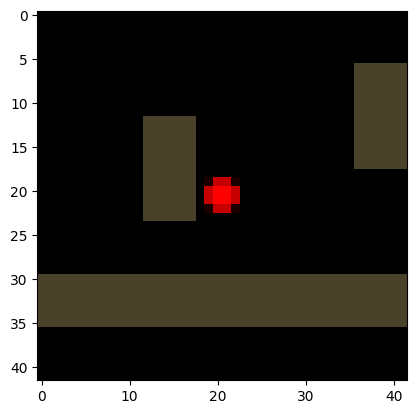

In [ ]:
# #| hide
# import matplotlib.pyplot as plt
# def unnormalize(img):
#     # img: tensor C×H×W
#     img = img.clone()
#     img = img * 0.5 + 0.5  # reverse Normalize((0.5),(0.5))
#     return img
# # img = unnormalize(img)
# plt.imshow(img.permute(1, 2, 0).numpy())
# plt.show()

In [ ]:
# dataset[0][0].shape

(42, 42, 3)

305 1
Action taken: Down


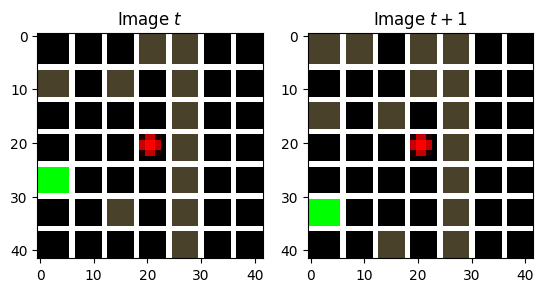

In [ ]:
# act_str = ["Right", "Down", "Left", "Up", "Done", "Toggle", "Pickup", "Drop"]
# def plot_two_ing_side_by_side(img1, img2):
#     # img1 = unnormalize(img1)
#     # img2 = unnormalize(img2)

#     import cv2
#     import matplotlib.pyplot as plt
#     def show_grid(img, GRID = 7, CELL = 6):
#         if not CELL:
#             CELL = img.shape[0] // GRID
        
#         vis = img.copy()
#         for i in range(1, GRID):
#             cv2.line(vis, (i*CELL, 0), (i*CELL, 42), (255,255,255), 1)
#             cv2.line(vis, (0, i*CELL), (42, i*CELL), (255,255,255), 1)
#         return vis
    
#     fig, axs = plt.subplots(1, 2)

#     vis1 = show_grid(img1, GRID=7, CELL=6)
#     vis2 = show_grid(img2, GRID=7, CELL=6)

#     axs[0].imshow(vis1)
#     axs[0].set_title('Image $t$')

#     axs[1].imshow(vis2)
#     axs[1].set_title('Image $t+1$')
#     plt.savefig("example2.png")
#     plt.show()

# indx = 305#np.random.randint(0, len(dataset)-2)
# print(indx, dataset[indx][1])
# img1 = dataset[indx][0]
# print(f"Action taken: {act_str[dataset[indx][1]]}")
# img2 = dataset[indx + 1][0]
# plot_two_ing_side_by_side(img1, img2)

In [ ]:
# # check equality of both tensors
# torch.equal(img2, dataset[indx + 1][0])

True

In [ ]:
# print(action)

3


### Sampler

In [ ]:
# #| hide
# from mawm.data.utils import lejepa_train_tf, BufferAwareConcatDataset
# from mawm.data.loaders import RolloutObservationDataset
# ds1 = RolloutObservationDataset(
#     agent='agent_0',
#     root='../marl_grid_data/',
#     transform=lejepa_train_tf,
#     buffer_size=10,
#     train=True
# )

# ds2 = RolloutObservationDataset(
#     agent='agent_1',
#     root='../marl_grid_data/',
#     transform=lejepa_train_tf,
#     buffer_size=10,
#     train=True
# )

# dataset_train = BufferAwareConcatDataset(datasets= [ds1, ds2])

Loading file buffer ...: 100%|██████████| 10/10 
Loading file buffer ...: 100%|██████████| 10/10 


In [ ]:
# #| hide
# from mawm.data.loaders import LejepaVisionDataset
# from torchvision import transforms
# void_transform = transforms.Lambda(lambda x: x)

# dataset_train = LejepaVisionDataset(dataset= dataset_train, transform= void_transform, V= 2)

In [ ]:
# void_transform = transforms.Lambda(lambda x: x)


In [ ]:
#| hide
import torch
import random

class EpisodeAwareSampler(torch.utils.data.Sampler):
    def __init__(self, dataset, batch_size, max_per_episode=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.max_per_episode = max_per_episode

        # build episode index ranges
        self.episode_ranges = []
        cum = dataset.ds.datasets[0]._cum_size
        for i in range(len(cum) - 1):
            self.episode_ranges.append(
                (cum[i], cum[i+1])
            )

    def __iter__(self):
        episodes = list(range(len(self.episode_ranges)))
        random.shuffle(episodes)

        batch = []
        for ep in episodes:
            lo, hi = self.episode_ranges[ep]
            idx = random.randint(lo, hi - 1)
            batch.append(idx)

            if len(batch) == self.batch_size:
                yield batch
                batch = []

    def __len__(self):
        return len(self.dataset) // self.batch_size


In [ ]:
# dataset_train.load_next_buffer()

Loading file buffer ...: 100%|██████████| 10/10 
Loading file buffer ...: 100%|██████████| 10/10 


In [ ]:
# dataset_train.ds.ds.ds.datasets

[<__main__.RolloutObservationDataset>,
 <__main__.RolloutObservationDataset>]

In [ ]:
# #| hide
# from torch.utils.data import DataLoader
# sampler = EpisodeAwareSampler(
#     dataset_train,
#     batch_size=5
# )

# train_loader = DataLoader(
#     dataset_train,
#     batch_sampler=sampler,
#     num_workers=0
# )


In [ ]:
# dataset_train.load_next_buffer()
# for batch in train_loader:
#     print(batch[2][0])
#     if batch[2][0] == 'agent_1':
#         print()
#         break

In [ ]:
# def denormalize(img):
#     # img: tensor C×H×W
#     img = img.clone()
#     img = img * 0.5 + 0.5  # reverse Normalize((0.5),(0.5))
#     return img

# img1 = denormalize(batch[0][0][0])
# img2 = denormalize(batch[0][1][0])

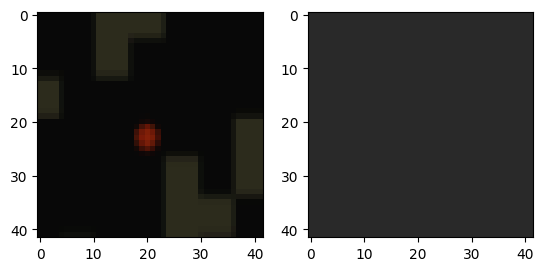

In [ ]:
# # plot two images side by side
# import matplotlib.pyplot as plt
# plt.subplot(1, 2, 1)
# plt.imshow(img1.permute(1, 2, 0).numpy())
# # plt.title(f"Done: {batch[0][1][0].item()}, Agent: {batch[2][0]}")
# plt.subplot(1, 2, 2)
# plt.imshow(img2.permute(1, 2, 0).numpy())
# # plt.title(f"Done: {batch[0][1][1].item()}, Agent: {batch[2][1]}")
# plt.show()

## Sequence Dataset

In [ ]:
#| export
class RolloutSequenceDataset(_RolloutDataset): # pylint: disable=too-few-public-methods
    """ Encapsulates rollouts.

    Rollouts should be stored in subdirs of the root directory, in the form of npz files,
    each containing a dictionary with the keys:
        - observations: (rollout_len, *obs_shape)
        - actions: (rovllout_len, action_size)
        - rewards: (rollout_len,)
        - terminals: (rollout_len,), boolean

     As the dataset is too big to be entirely stored in rams, only chunks of it
     are stored, consisting of a constant number of files (determined by the
     buffer_size parameter).  Once built, buffers must be loaded with the
     load_next_buffer method.

    Data are then provided in the form of tuples (obs, action, reward, terminal, next_obs):
    - obs: (seq_len, *obs_shape)
    - actions: (seq_len, action_size)
    - reward: (seq_len,)
    - terminal: (seq_len,) boolean
    - next_obs: (seq_len, *obs_shape)

    NOTE: seq_len < rollout_len in moste use cases

    :args root: root directory of data sequences
    :args seq_len: number of timesteps extracted from each rollout
    :args transform: transformation of the observations
    :args train: if True, train data, else test
    """
    def __init__(self, agent, root, seq_len, transform, buffer_size=200, train=True, obs_key='pov'): # pylint: disable=too-many-arguments
        super().__init__(agent, root, transform, buffer_size, train, obs_key)
        self._seq_len = seq_len
        self.agent = agent
         
    def __getitem__(self, i):
        file_index = bisect(self._cum_size, i) - 1
        seq_index = i - self._cum_size[file_index]
        data = self._buffer[file_index]
        
        # Ensure we don't go past the episode boundary
        episode_len = data['episode_len'].item()
        max_start = episode_len - self._seq_len - 1
        
        if seq_index > max_start:
            # This shouldn't happen if __len__ is correct
            # But as a safety, clamp it
            seq_index = max(0, max_start)
        
        return {**self._get_data(data, seq_index), 'index': i}
    
    def _get_agent_data(self, data, seq_index):
        data_dict = {}
        
        # Get obs[t] and obs[t+1] for t in [seq_index, seq_index+seq_len)
        obs_data = data[f'{self.agent}_obs'][seq_index:seq_index + self._seq_len + 1]
        
        # Transform observations
        obs_transformed = [self._transform(obs_data[i][self.obs_key].astype(np.uint8)) 
                        for i in range(len(obs_data))]
        
        # obs[t] and next_obs[t] = obs[t+1]
        obs = obs_transformed[:-1]        # length: seq_len
        next_obs = obs_transformed[1:]    # length: seq_len
        
        # Get actions, rewards, info that correspond to transitions
        # action[t] is the action taken at obs[t] leading to next_obs[t]
        action = data[f'{self.agent}_act'][seq_index:seq_index + self._seq_len]
        reward = data[f'{self.agent}_rew'][seq_index:seq_index + self._seq_len]
        info = data[f'{self.agent}_info'][seq_index:seq_index + self._seq_len]
        
        # Stack obs into tensors for easier collation
        data_dict["obs"] = torch.stack(obs)           # (seq_len, C, H, W)
        data_dict["next_obs"] = torch.stack(next_obs) # (seq_len, C, H, W)
        data_dict["act"] = torch.from_numpy(action.astype(np.float32))  # (seq_len, action_dim)
        data_dict["rew"] = torch.from_numpy(reward.astype(np.float32))  # (seq_len,)
        data_dict["info"] = info  # Keep as is or remove if not needed
        
        return data_dict

    def _get_data(self, data, seq_index):
        return self._get_agent_data(data, seq_index)

    def _data_per_sequence(self, data_length):
        return data_length - self._seq_len


In [ ]:
# #| hide
# from mawm.data.utils import transform_train, transform_test
# from torchvision import transforms
# import numpy as np

# ASIZE, LSIZE, RSIZE, RED_SIZE, SIZE =\
#     3, 32, 256, 32, 40

# tf = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((40, 40)),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
# ])

# dataset = RolloutSequenceDataset(
#     agent='agent_0',
#     root='../datasets/marl_grid_data/',
#     transform=tf,
#     train=True,
#     seq_len=50,
#     buffer_size=10
# )

In [ ]:
# #| hide
# import torch

# def custom_collate(batch):
#     """Collate batch of dicts containing tensors"""
#     batch_dict = {}
    
#     for key in batch[0].keys():
#         if key == 'info':
#             # Keep info as list (don't collate objects)
#             batch_dict[key] = torch.stack([item[key] for item in batch]).flatten(0, 1)
#         else:
#             # Stack tensors along batch dimension
#             batch_dict[key] = torch.stack([item[key] for item in batch])
    
#     return batch_dict

# def flatten_sequence_collate(batch):
#     """Collate and flatten sequences into individual frames"""
#     batch_dict = {}
    
#     for key in batch[0].keys():
#         if key == 'info':
#             batch_dict[key] = np.stack([item[key] for item in batch]).reshape(-1)
#         else:
#             # Stack along batch dimension: (batch_size, seq_len, ...)
#             stacked = torch.stack([item[key] for item in batch])
            
#             # Flatten batch and seq_len: (batch_size * seq_len, ...)
#             batch_dict[key] = stacked.flatten(0, 1)
    
#     return batch_dict


# train_loader = torch.utils.data.DataLoader(
#     dataset, 
#     batch_size=32, 
#     shuffle=True, 
#     num_workers=0,
#     collate_fn=flatten_sequence_collate
# )

Loading file buffer ...: 100%|██████████| 10/10 


In [ ]:
# #| hide
# train_loader.dataset.load_next_buffer()

In [ ]:
# train_loader = torch.utils.data.DataLoader(
#         dataset, batch_size=32, shuffle=True, num_workers=0)


Loading file buffer ...: 100%|██████████| 10/10 


In [ ]:
# #| hide
# for batch in train_loader:
#     print(batch.keys())
#     break

dict_keys(['obs', 'next_obs', 'act', 'rew', 'info'])


In [ ]:
# #| hide
# batch['obs'].shape, batch['next_obs'].shape, batch['act'].shape, batch['rew'].shape, batch['info'].shape   


(torch.Size([1600, 3, 40, 40]),
 torch.Size([1600, 3, 40, 40]),
 torch.Size([1600]),
 torch.Size([1600]),
 (1600,))

In [ ]:
# #| hide
# batch['info'][1599]

{'done': True,
 'comm': 0,
 'nonadv_done': False,
 'posd': array([6, 5, 1]),
 'sees_goal': 1,
 'comm_str': ''}

In [ ]:
# #| hide
# batch_data = dataset[0]
# batch_data.keys()

dict_keys(['obs', 'next_obs', 'act', 'rew', 'info'])

## Lejepa vision dataset


In [ ]:
#| export
import torch
class LejepaVisionDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform, V=1):
        self.V = V
        self.ds = dataset
        self.tf = transform
        self.load_next_buffer = dataset.load_next_buffer
        
    def __getitem__(self, i):
        img, done, agent = self.ds[i]
        return torch.stack([self.tf(img) for _ in range(self.V)]), done, agent

    def __len__(self):
        return len(self.ds)

## D4RL DS


In [ ]:
import torch
from torch.utils.data import Dataset

class D4RLTransitionDataset(Dataset):
    def __init__(self, hf_dataset):
        self.ds = hf_dataset

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        row = self.ds[idx]

        obs = torch.tensor(row["obs"], dtype=torch.float32)
        act = torch.tensor(row["action"], dtype=torch.long)
        next_obs = torch.tensor(row["next_obs"], dtype=torch.float32)

        return {
            "obs": obs,
            "action": act,
            "next_obs": next_obs,
        }


In [ ]:
import torch
class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, ds, episode_indices, seq_len= 100, num_agents=2):
        self.ds = ds
        self.episode_indices = episode_indices
        self.seq_len = seq_len
        self.episodes = list(episode_indices.keys())
        self.agents = [f"agent_{i}" for i in range(num_agents)]
    
    def __len__(self):
        return sum(
            max(0, len(idxs) - self.seq_len)
            for idxs in self.episode_indices.values()
        )

    def __getitem__(self, _):
        ep = np.random.choice(self.episodes)
        idxs = self.episode_indices[ep]

        start = np.random.randint(0, len(idxs) - self.seq_len)
        seq = idxs[start:start + self.seq_len]# % len(self.ds)

        return {
            f"{ag}": 
                    {
                    "obs": self.ds[seq][f"{ag}_obs"],
                    "act": self.ds[seq][f"{ag}_act"],
                    "next_obs": self.ds[seq][f"{ag}_next_obs"],
                    "done": self.ds[seq][f"{ag}_done"],
                    } 
            for ag in (self.agents)}


In [ ]:
#| export
from datasets import load_from_disk, concatenate_datasets
import torch
class D4RL(torch.utils.data.Dataset): 
    def __init__(self, data_path, transform, buffer_size=1, seq_len= 100, train=True, obs_key = 'pov'):
        
        self._transform = transform
        self.obs_key = obs_key
        self.seq_len = seq_len
        self._files = [join(data_path, sd) for sd in listdir(data_path)]

        def train_test_split(files, train):
            if train:
                return files[:-600]
            else:
                return files[-600:]

        self._files = train_test_split(self._files, train)
        self._cum_size = None
        self._buffer = None
        self._buffer_fnames = None
        self._buffer_index = 0
        self._buffer_size = buffer_size
        
    def __len__(self):
        if not self._cum_size:
            self.load_next_buffer()
        return len(self.ds)

    def load_next_buffer(self):
        """ Loads next buffer """
        self._buffer_fnames = self._files[self._buffer_index:self._buffer_index + self._buffer_size]
        self._buffer_index += self._buffer_size
        self._buffer_index = self._buffer_index % len(self._files)
        self._buffer = []
        self._cum_size = [0]

        for p in self._buffer_fnames:
            self._buffer.append(load_from_disk(p))
            self._cum_size += [self._cum_size[-1] + self.seq_len]
        self.ds = concatenate_datasets(self._buffer)


    def __getitem__(self, i):
        return self.ds[i]
    
    def reset_buffer(self):
        self._buffer = None
        self._cum_size = None
        self._buffer_fnames = None
        self._buffer_index = 0  


In [ ]:
import torch
import numpy as np
from collections import defaultdict
from datasets import load_from_disk
from os.path import join
from os import listdir

class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, seq_len=100, num_agents=2, sequences_per_dataset=1000):
        self.seq_len = seq_len
        self.agents = [f"agent_{i}" for i in range(num_agents)]
        self.sequences_per_dataset = sequences_per_dataset
        
        # Get all dataset paths
        self.all_ds_paths = sorted([join(data_path, sd) for sd in listdir(data_path)])
        self.current_ds_idx = 0
        
        # Current dataset state
        self.ds = None
        self.episode_indices = None
        self.episodes = None
        self._samples_from_current = 0
        
        # Load first dataset
        self._load_next_dataset()
    
    def _load_next_dataset(self):
        """Load the next dataset and build episode indices"""
        # Free previous dataset
        if self.ds is not None:
            del self.ds
            self.episode_indices = None
            self.episodes = None
        
        # Load next dataset
        ds_path = self.all_ds_paths[self.current_ds_idx]
        print(f"Loading dataset {self.current_ds_idx + 1}/{len(self.all_ds_paths)}: {ds_path}")
        self.ds = load_from_disk(ds_path)
        
        # Build episode indices
        self.episode_indices = defaultdict(list)
        for i in range(len(self.ds)):
            self.episode_indices[self.ds[i]["rollout_idx"]].append(i)
        
        # Filter episodes that are long enough
        self.episodes = [
            ep for ep, idxs in self.episode_indices.items()
            if len(idxs) >= self.seq_len
        ]
        
        if not self.episodes:
            raise ValueError(f"No episodes with length >= {self.seq_len} in {ds_path}")
        
        # Move to next dataset index (circular)
        self.current_ds_idx = (self.current_ds_idx + 1) % len(self.all_ds_paths)
        self._samples_from_current = 0
    
    def __len__(self):
        # Return total possible sequences across all datasets
        # This is an estimate - actual number depends on episode structure
        return len(self.all_ds_paths) * self.sequences_per_dataset
    
    def __getitem__(self, idx):
        # Check if we should load next dataset
        if self._samples_from_current >= self.sequences_per_dataset:
            self._load_next_dataset()
        
        self._samples_from_current += 1
        
        # Sample random episode
        ep = np.random.choice(self.episodes)
        idxs = self.episode_indices[ep]
        
        # Sample random start point
        start = np.random.randint(0, len(idxs) - self.seq_len + 1)
        seq = idxs[start:start + self.seq_len]
        
        # Get data
        batch = self.ds[seq]
        
        return {
            ag: {
                "obs": batch[f"{ag}_obs"],
                "act": batch[f"{ag}_act"],
                "next_obs": batch[f"{ag}_next_obs"],
                "done": batch[f"{ag}_done"],
            }
            for ag in self.agents
        }

In [ ]:
# meta_paths = "../datasets/marl_grid_data_hf/merged_dataset/metadata_merged.npz"
# import numpy as np
# meta_data = np.load(meta_paths, allow_pickle=True)
# meta_data['rollout_0_episode_len']

array(512)

In [ ]:
import torch
import numpy as np
from datasets import load_from_disk
from os.path import join
from os import listdir

class D4RLSequenceDataset(torch.utils.data.IterableDataset):
    def __init__(self, data_path, seq_len=100, num_agents=2, train=True, 
                 buffer_size=5, shuffle_files=True):
        self.seq_len = seq_len
        self.agents = [f"agent_{i}" for i in range(num_agents)]
        self.buffer_size = buffer_size
        self.shuffle_files = shuffle_files
        
        # Get all dataset files
        all_files = sorted([join(data_path, sd) for sd in listdir(data_path)])
        all_files = [f for f in all_files if f.endswith('.arrow')]
        print(all_files)
        # Train/test split
        if train:
            self.files = all_files[:-600]
        else:
            self.files = all_files[-600:]
    
    def _process_dataset(self, ds):
        """Extract sequences from a single dataset"""
        # Group by episodes if your data has episode info
        # Otherwise, just sample sequences from the dataset
        
        max_start = len(ds) - self.seq_len
        if max_start <= 0:
            return
        
        # Generate random starting points
        num_sequences = max(1, max_start // 10)  # Adjust sampling rate
        starts = np.random.randint(0, max_start, size=num_sequences)
        
        for start in starts:
            seq = range(start, start + self.seq_len)
            batch = ds[seq]
            
            yield {
                ag: {
                    "obs": batch[f"{ag}_obs"],
                    "act": batch[f"{ag}_act"],
                    "next_obs": batch[f"{ag}_next_obs"],
                    "done": batch[f"{ag}_done"],
                }
                for ag in self.agents
            }
    
    def __iter__(self):
        files = self.files.copy()
        if self.shuffle_files:
            np.random.shuffle(files)
        
        # Process files in chunks (buffer)
        for i in range(0, len(files), self.buffer_size):
            buffer_files = files[i:i + self.buffer_size]
            print(buffer_files)
            # Load buffer
            datasets = [load_from_disk(f) for f in buffer_files]
            
            # Shuffle datasets within buffer
            if self.shuffle_files:
                np.random.shuffle(datasets)
            
            # Yield sequences from each dataset
            for ds in datasets:
                yield from self._process_dataset(ds)
                del ds  # Free memory
            
            datasets.clear()

In [ ]:
# dss = D4RLSequenceDataset(
#     data_path="../datasets/marl_grid_data_hf/merged_dataset/",
#     seq_len=50,
#     num_agents=2,
#     train=True,
#     buffer_size=2,
#     shuffle_files=True
# )
# loader = torch.utils.data.DataLoader(
#     dss,
#     batch_size=4,
#     num_workers=0
# )

['../datasets/marl_grid_data_hf/merged_dataset/data-00000-of-00001.arrow']


In [ ]:
class SequenceIterableDataset(torch.utils.data.IterableDataset):
    def __init__(self, data_path, seq_len=100, num_agents=2, 
                 samples_per_episode=5, shuffle_datasets=True):
        self.seq_len = seq_len
        self.agents = [f"agent_{i}" for i in range(num_agents)]
        self.samples_per_episode = samples_per_episode
        self.shuffle_datasets = shuffle_datasets
        
        # Get all dataset paths
        self.all_ds_paths = sorted([join(data_path, sd) for sd in listdir(data_path) if sd.endswith('.arrow')])
    
    def _process_dataset(self, ds):
        """Extract sequences from a dataset"""
        # Build episode indices
        episode_indices = defaultdict(list)
        for i in range(len(ds)):
            episode_indices[ds[i]["rollout_idx"]].append(i)
        
        # Filter valid episodes
        valid_episodes = [
            (ep, idxs) for ep, idxs in episode_indices.items()
            if len(idxs) >= self.seq_len
        ]
        
        if not valid_episodes:
            return
        
        # Sample from each episode
        for ep, idxs in valid_episodes:
            max_starts = len(idxs) - self.seq_len + 1
            num_samples = min(self.samples_per_episode, max_starts)
            
            starts = np.random.choice(max_starts, size=num_samples, replace=False)
            
            for start in starts:
                seq = idxs[start:start + self.seq_len]
                batch = ds[seq]
                
                yield {
                    ag: {
                        "obs": batch[f"{ag}_obs"],
                        "act": batch[f"{ag}_act"],
                        "next_obs": batch[f"{ag}_next_obs"],
                        "done": batch[f"{ag}_done"],
                    }
                    for ag in self.agents
                }
    
    def __iter__(self):
        # Shuffle dataset order each epoch
        ds_paths = self.all_ds_paths.copy()
        if self.shuffle_datasets:
            np.random.shuffle(ds_paths)
        
        # Process each dataset
        for ds_path in ds_paths:
            ds = load_from_disk(ds_path)
            yield from self._process_dataset(ds)
            del ds  # Free memory immediately



In [ ]:
# # Usage
# dataset = SequenceIterableDataset(
#     data_path="../datasets/marl_grid_data_hf/merged_dataset/",
#     seq_len=100,
#     num_agents=2,
#     samples_per_episode=5
# )

# dataloader = torch.utils.data.DataLoader(
#     dataset,
#     batch_size=32,
#     num_workers=2
# )

In [ ]:
# ds = D4RLSequenceDataset(
#     data_path='../datasets/marl_grid_data_hf/merged_dataset',
#     seq_len=50,
#     num_agents=1,
#     train=True,
#     buffer_size=2,
#     shuffle_files=True
# )

In [ ]:
# for sample in ds:
#     print(sample)
#     break

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()